# Tidying "life_expectancy" dataset

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import re
from fuzzywuzzy import fuzz
from scipy.stats import shapiro
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import MinMaxScaler

## 1. Overview and initial data quality assessment

In [2]:
# ingest file
file = "life_expectancy.csv"
df = pd.read_csv(file)

In [3]:
# inspect dataset dimensions
df.shape

(2938, 22)

In [4]:
# overview of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Country                          2938 non-null   object 
 1   Year                             2938 non-null   int64  
 2   Status                           2938 non-null   object 
 3   Life expectancy                  2928 non-null   float64
 4   Adult Mortality                  2928 non-null   float64
 5   infant deaths                    2938 non-null   int64  
 6   Alcohol                          2744 non-null   float64
 7   percentage expenditure           2938 non-null   float64
 8   Hepatitis B                      2385 non-null   float64
 9   Measles                          2938 non-null   int64  
 10   BMI                             2904 non-null   float64
 11  under-five deaths                2938 non-null   int64  
 12  Polio               

In [5]:
# inspect missing values in dataset
df.isnull().sum()

Country                              0
Year                                 0
Status                               0
Life expectancy                     10
Adult Mortality                     10
infant deaths                        0
Alcohol                            194
percentage expenditure               0
Hepatitis B                        553
Measles                              0
 BMI                                34
under-five deaths                    0
Polio                               19
Total expenditure                  226
Diphtheria                          19
 HIV/AIDS                            0
GDP                                448
Population                         652
 thinness  1-19 years               34
 thinness 5-9 years                 34
Income composition of resources    167
Schooling                          163
dtype: int64

In [6]:
# calculate number of columns with incomplete values
incomplete_columns = len(df.columns) - (df.isnull().sum().value_counts()[0])
print(incomplete_columns)

14


In [7]:
# check for duplicates
df.duplicated().sum()

0

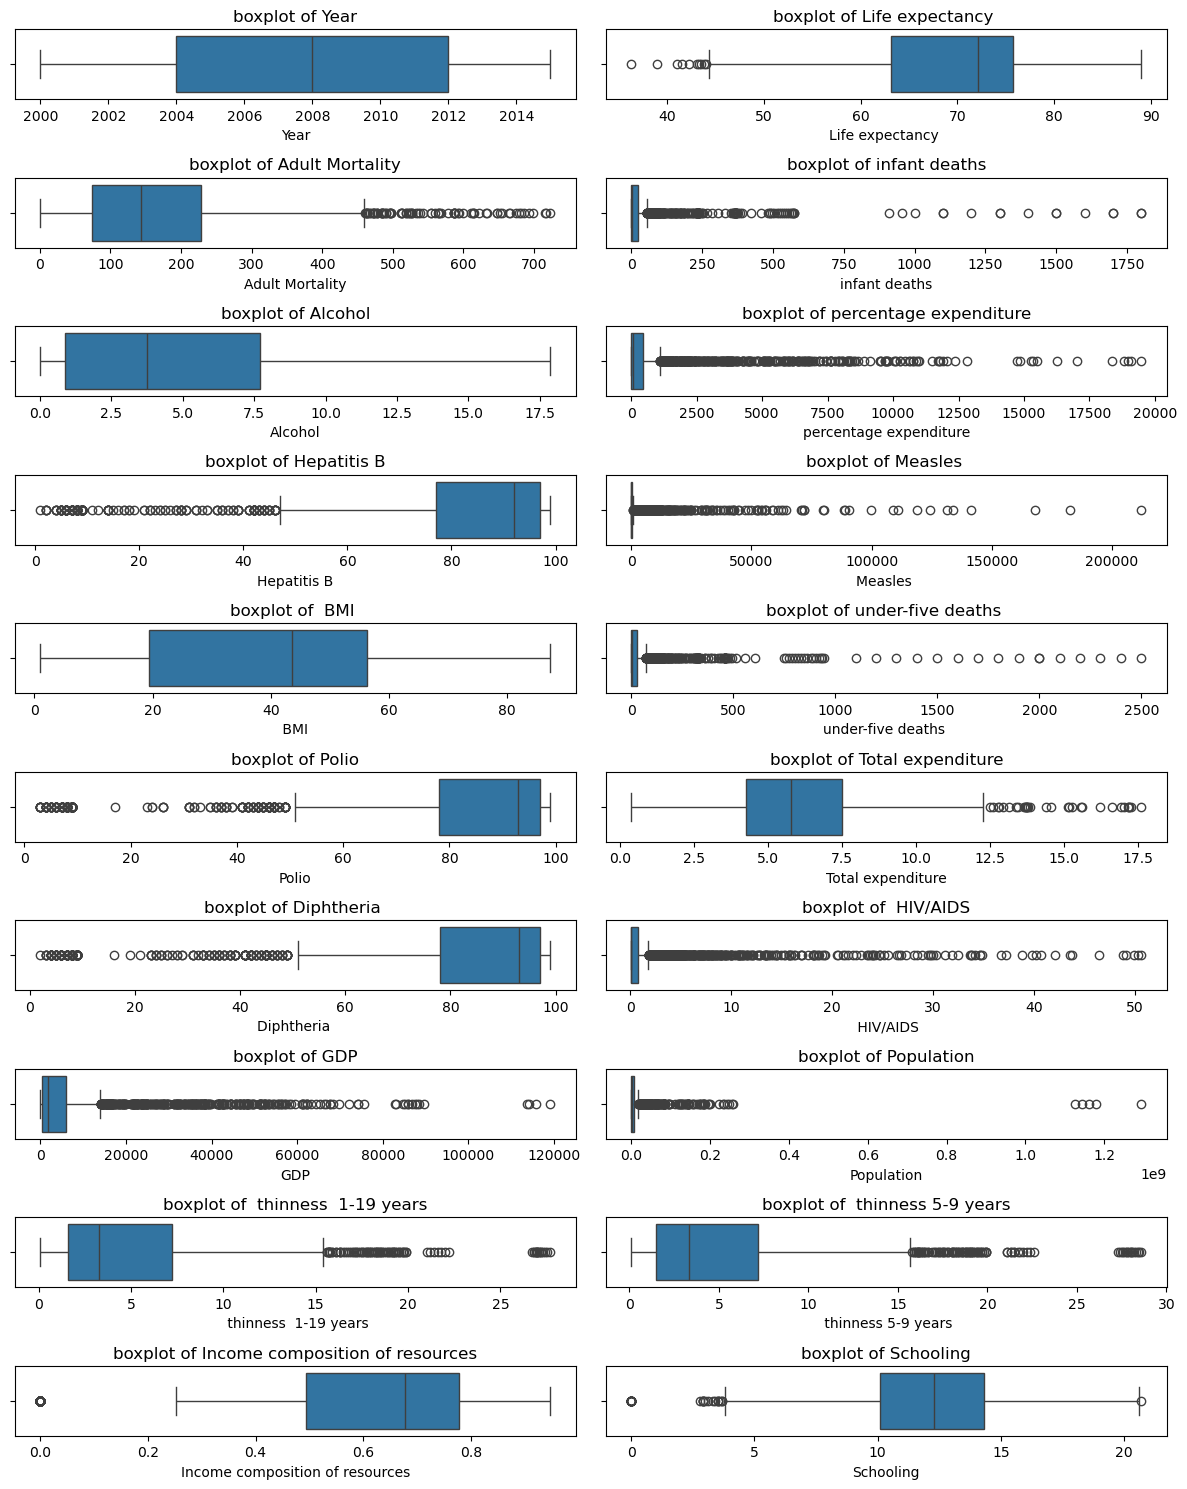

In [8]:
# check for potential outliers using boxplot visualization
df_num = df.select_dtypes(exclude="object")

plt.figure(figsize=(12,15))
for i, data in enumerate(df_num.columns):
    plt.subplot(10, 2, i+1)
    plt.title(f"boxplot of {data}")
    sns.boxplot(x=df_num[data])
plt.tight_layout()
plt.show()

In [9]:
df.describe()

,Year,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
count,2938.000000,2928.000000,2928.000000,2938.000000,2744.000000,2938.000000,2385.000000,2938.000000,2904.000000,2938.000000,2919.000000,2712.00000,2919.000000,2938.000000,2490.000000,2.286000e+03,2904.000000,2904.000000,2771.000000,2775.000000
mean,2007.518720,69.224932,164.796448,30.303948,4.602861,738.251295,80.940461,2419.592240,38.321247,42.035739,82.550188,5.93819,82.324084,1.742103,7483.158469,1.275338e+07,4.839704,4.870317,0.627551,11.992793
std,4.613841,9.523867,124.292079,117.926501,4.052413,1987.914858,25.070016,11467.272489,20.044034,160.445548,23.428046,2.49832,23.716912,5.077785,14270.169342,6.101210e+07,4.420195,4.508882,0.210904,3.358920
min,2000.000000,36.300000,1.000000,0.000000,0.010000,0.000000,1.000000,0.000000,1.000000,0.000000,3.000000,0.37000,2.000000,0.100000,1.681350,3.400000e+01,0.100000,0.100000,0.000000,0.000000
25%,2004.000000,63.100000,74.000000,0.000000,0.877500,4.685343,77.000000,0.000000,19.300000,0.000000,78.000000,4.26000,78.000000,0.100000,463.935626,1.957932e+05,1.600000,1.500000,0.493000,10.100000
50%,2008.000000,72.100000,144.000000,3.000000,3.755000,64.912906,92.000000,17.000000,43.500000,4.000000,93.000000,5.75500,93.000000,0.100000,1766.947595,1.386542e+06,3.300000,3.300000,0.677000,12.300000
75%,2012.000000,75.700000,228.000000,22.000000,7.702500,441.534144,97.000000,360.250000,56.200000,28.000000,97.000000,7.49250,97.000000,0.800000,5910.806335,7.420359e+06,7.200000,7.200000,0.779000,14.300000
max,2015.000000,89.000000,723.000000,1800.000000,17.870000,19479.911610,99.000000,212183.000000,87.300000,2500.000000,99.000000,17.60000,99.000000,50.600000,119172.741800,1.293859e+09,27.700000,28.600000,0.948000,20.700000


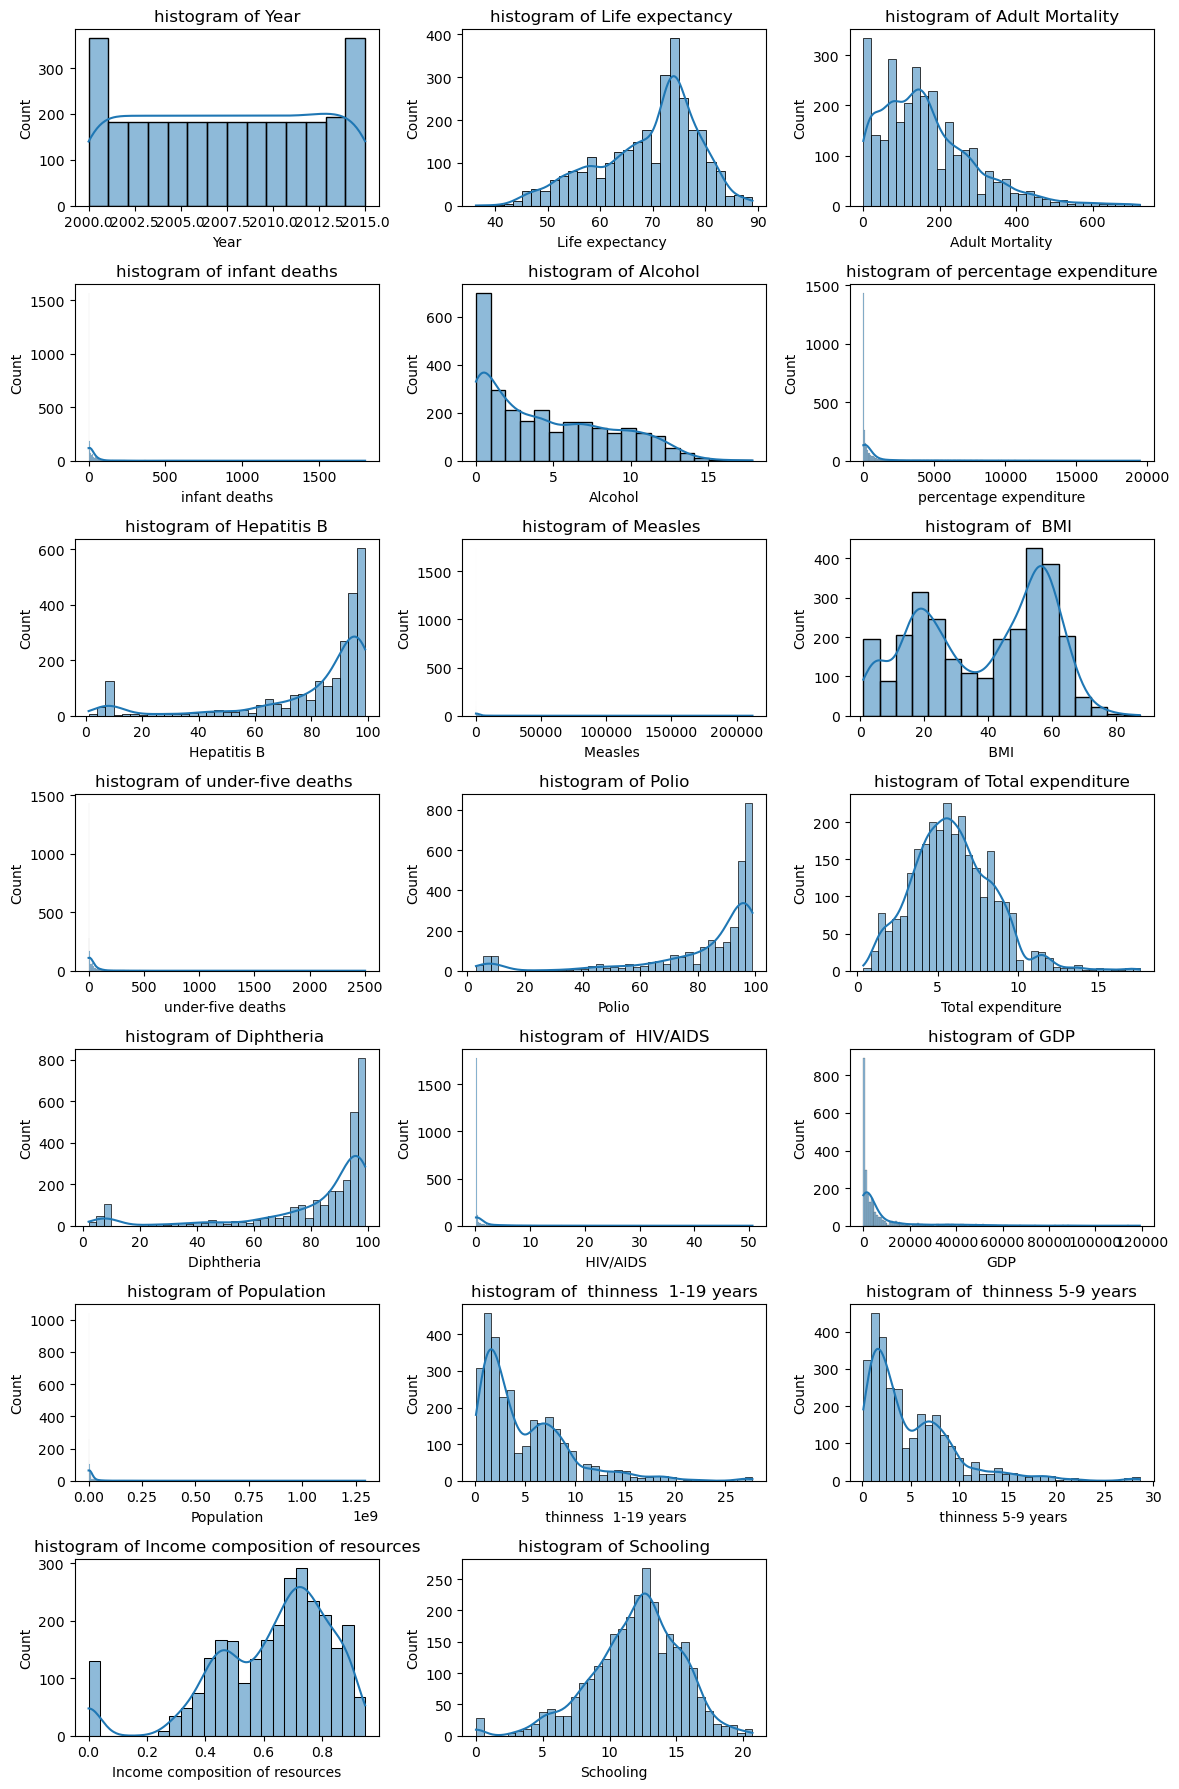

In [10]:
# inspect distribution of numerical variables
plt.figure(figsize=(12,18))
for i, data in enumerate(df_num.columns):
    plt.subplot(7, 3, i+1)
    plt.title(f"histogram of {data}")
    sns.histplot(df_num[data], kde=True)
plt.tight_layout()
plt.show()

## 2. Column names

In [11]:
# decapitalize column names
df.rename(str.lower, axis="columns", inplace=True)


# remove leading, trailing and multiple spaces
column_names = df.columns.to_list()
new_names = {column_names[i]:column_names[i] for i in range(len(column_names))}

# define search and replacement strings for regex in a dictionary
# leading space: "^ ", trailing space: " $", multiple spaces: " + "
search_replace = {"^ ": "" , " $": "", " + ": " "}

for str in search_replace:
    for name in new_names:
        if re.search(str, new_names[name]):
            new_names[name] = re.sub(str, search_replace[str], new_names[name])


# make names more pythonic by replacing spaces and dashes in column names
# define search and replacement strings for regex in a dictionary
search_replace = {" ": "_", "-": "_"}

for str in search_replace:
    for name in new_names:
        if re.search(str, new_names[name]):
            new_names[name] = re.sub(str, search_replace[str], new_names[name])

# rename all columns
df.rename(columns=new_names, inplace=True)

## 3. Duplicates

In [12]:
# check for partial duplicates within country and year
df.duplicated(subset=["country", "year"]).sum()

0

In [13]:
# check number of unique entries in country
len(df["country"].unique())

193

In [14]:
# check if fuzzy duplicates exist among country names
country_list = df["country"].unique()

fuzzy_pairs = []

# find string pairs with fuzzy ratio greater or equal 75
for country_1 in range(len(country_list) - 1):
    for country_2 in range(len(country_list) -1):
        if fuzz.ratio(country_list[country_1], country_list[country_2]) >= 75:
            if country_1 != country_2:
                country_tuple = (country_list[country_1], country_list[country_2])
                fuzzy_pairs.append(country_tuple)

# inspect potential fuzzy duplicates
for pair in fuzzy_pairs:
    print(pair)

('Argentina', 'Armenia')
('Armenia', 'Argentina')
('Australia', 'Austria')
('Austria', 'Australia')
('Gambia', 'Namibia')
('Gambia', 'Zambia')
('Iceland', 'Ireland')
('Ireland', 'Iceland')
('Malawi', 'Mali')
('Mali', 'Malawi')
('Namibia', 'Gambia')
('Namibia', 'Zambia')
('Niger', 'Nigeria')
('Nigeria', 'Niger')
('Pakistan', 'Tajikistan')
('Republic of Korea', 'Republic of Moldova')
('Republic of Moldova', 'Republic of Korea')
('Slovakia', 'Slovenia')
('Slovenia', 'Slovakia')
('Tajikistan', 'Pakistan')
('Zambia', 'Gambia')
('Zambia', 'Namibia')


## 4. Missing values

In [15]:
# calculate fraction of rows with missing values
complete_rows = df.isnull().sum(axis=1).value_counts()[0]
missing_rows = df.shape[0] - complete_rows

missing_rows_fraction = (missing_rows/df.shape[0] * 100).round(1)

# calculate fracton of columns with missing value
complete_columns = df.isnull().sum().value_counts()[0]
missing_columns = df.shape[1] - complete_columns

missing_columns_fraction = (missing_columns/df.shape[1] * 100).round(1)

print(f"%Rows with missing values: {missing_rows_fraction}\n" +
      f"%Columns with missing values: {missing_columns_fraction}")

%Rows with missing values: 43.9
%Columns with missing values: 63.6


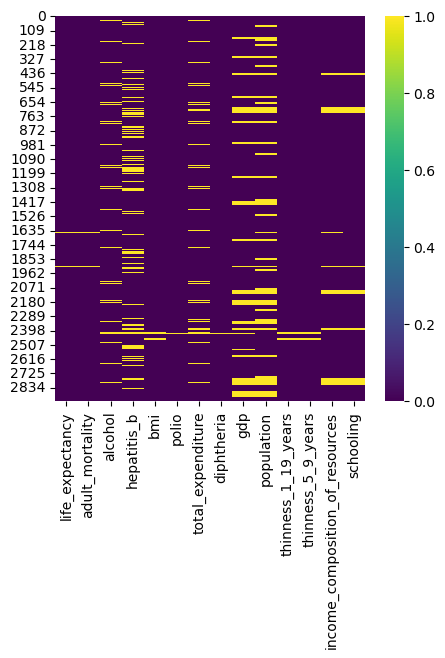

In [16]:
# examine how missing data is distributed
df_null = df.loc[:, df.isna().any()]

plt.figure(figsize=(5,5))
sns.heatmap(df_null.isnull(), cmap="viridis")
plt.show()

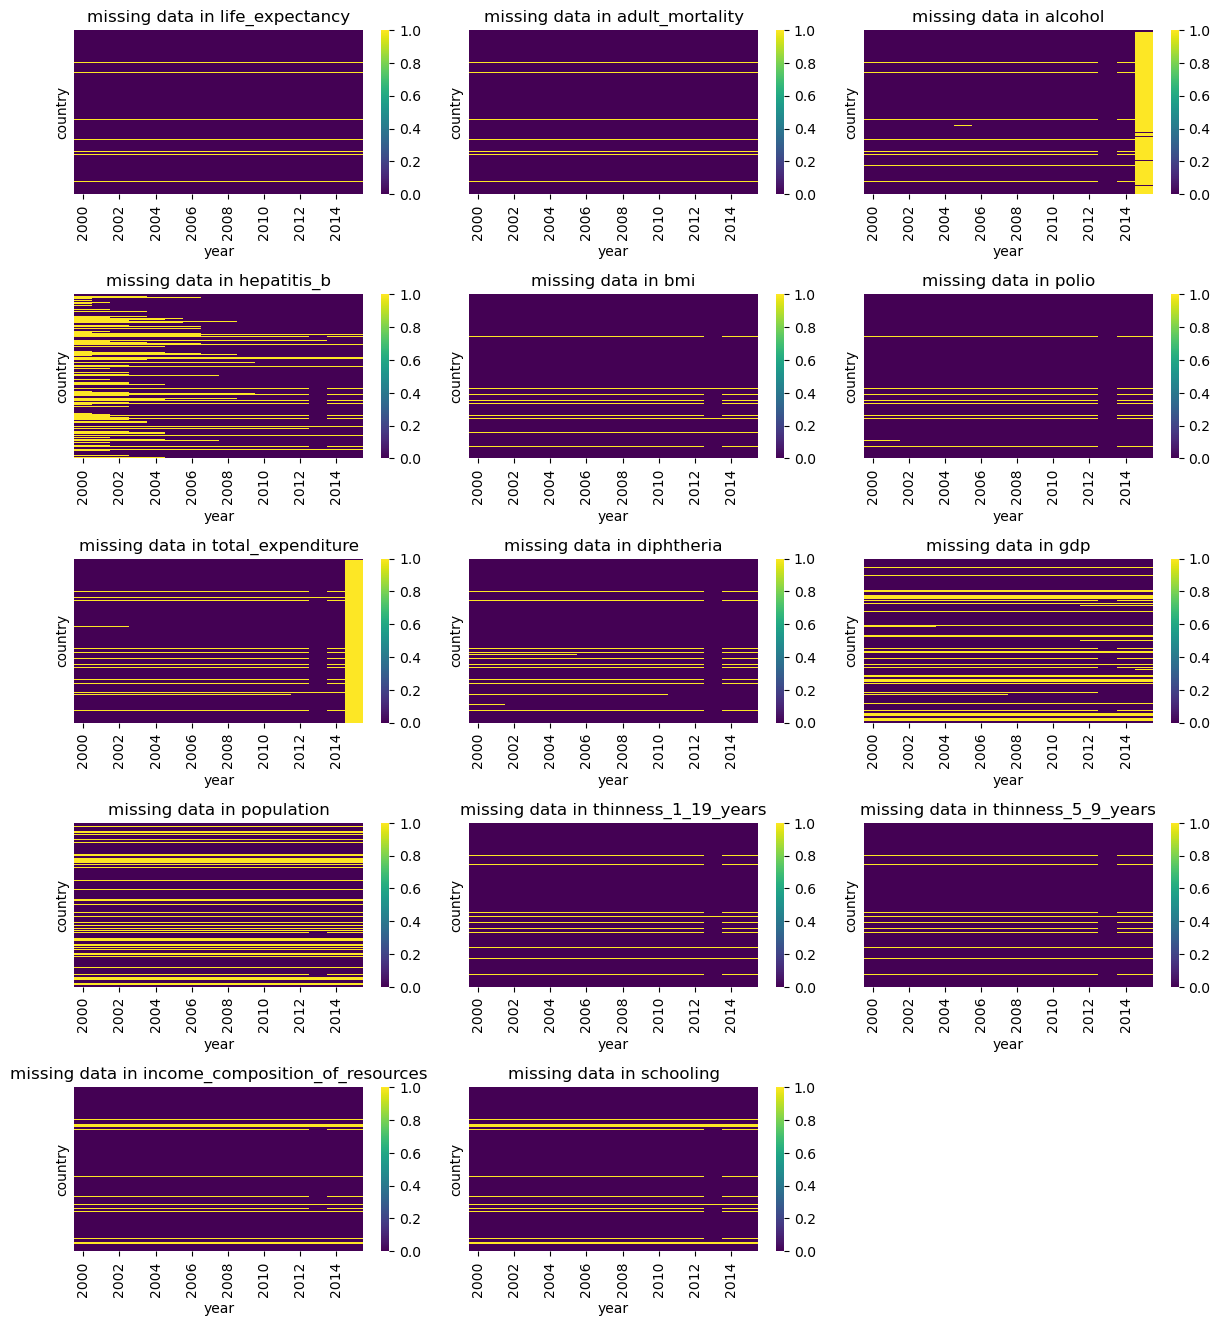

In [17]:
# plot the distribution of missing values in relation to country and year
# pivot dataframe for every column that contains missing data
pivot_dict = {}
for column in df_null:
    pivot_dict[column] = pd.pivot_table(df, values=column, index=["country"], columns=["year"], dropna=False)
    
# plot distribution using heatmap
plt.figure(figsize=(12,18))
for i, pivot in enumerate(pivot_dict):
    plt.subplot(7, 3, i+1)
    plt.title(f"missing data in {pivot}")
    sns.heatmap(pivot_dict[pivot].isnull(), yticklabels=False, cmap="viridis")
plt.tight_layout()
plt.show()

## 5. Outliers and bad data

In [18]:
# test numerical data for normal distribution using shapiro-wilk test
shapiro_list = {column:shapiro(df_num[column].dropna()) for column in df_num.columns}

# define significance limit
p_limit = 0.01

# print variables that do not significantly differ from normal distribution
norm_list = []
for variable in shapiro_list:
    if shapiro_list[variable][1] > p_limit:
        norm_list.append(variable, shapiro_list[variable][1])

print(norm_list)

[]


### Column metadata
| column | description | expected range |
| ------ | ----------- | ------- |
| country | Country | - |
| year | Year | 2000-2015 |
| status | Developed or developing status | - |
| life_expectancy | Life Expectancy in age | 0-120 |
| adult_mortality | Adult Mortality Rates of both sexes (probability of dying between 15 and 60 years per 1000 population) | 0-1000 |
| infant_deaths | Number of Infant Deaths per 1000 population | 0-1000 |
| alcohol | Alcohol, recorded per capita (15+) consumption (in litres of pure alcohol) | 0-unknown |
| percentage_expenditure | Expenditure on health as a percentage of Gross Domestic Product per capita (%) | 0-unknown |
| hepatitis_b | Hepatitis B (HepB) immunization coverage among 1-year-olds (%) | 0-100 |
| measles | Measles - number of reported cases per 1000 population | 0-1000 |
| bmi | Average Body Mass Index of entire population | 10-40 |
| under_five_deaths | Number of under-five deaths per 1000 population | 0-1000 |
| polio | Polio (Pol3) immunization coverage among 1-year-olds (%) | 0-100 |
| total_expenditure | General government expenditure on health as a percentage of total government expenditure (%) | 0-100 |
| diphtheria | Diphtheria tetanus toxoid and pertussis (DTP3) immunization coverage among 1-year-olds (%) | 0-100 |
| hiv/aids | Deaths per 1000 live births HIV/AIDS (0-4 years) | 0-1000 |
| gdp | Gross Domestic Product per capita (in USD) | 0-unknown |
| population | Population of the country | 0-unknown |
| thinness_1_19_years | Prevalence of thinness among children and adolescents for Age 10 to 19 (%) | 0-100 |
| thinness_5_9_years | Prevalence of thinness among children for Age 5 to 9 (%) | 0-100 |
| income_composition_of_resources | Human Development Index in terms of income composition of resources (index ranging from 0 to 1) | 0-1
| schooling | Number of years of Schooling (years) | 0-30

In [19]:
# create dictionary containing upper and lower limits of numerical data
limit_dict = {"year": (2000, 2015),
              "life_expectancy": (0, 120),
              "adult_mortality": (0, 1000),
              "infant_deaths": (0, 1000),
              "alcohol": (0, np.inf),
              "percentage_expenditure": (0, np.inf),
              "hepatitis_b": (0, 100),
              "measles": (0, 1000),
              "bmi": (10, 40),
              "under_five_deaths": (0, 1000),
              "polio": (0, 100),
              "total_expenditure": (0, np.inf),
              "diphtheria": (0, 100),
              "hiv/aids": (0, 1000),
              "gdp": (0, np.inf),
              "population": (0, np.inf),
              "thinness_1_19_years": (0, 100),
              "thinness_5_9_years": (0, 100),
              "income_composition_of_resources": (0, 1),
              "schooling": (0, 30)}

# check columns for logically impossible value (based on limits)
bad_data_lower = []
bad_data_upper = []
for column in limit_dict:
    if df[column].min() < limit_dict[column][0]:
        bad_data_lower.append(column)
    if df[column].max() > limit_dict[column][1]:
        bad_data_upper.append(column)

print(bad_data_lower)
print(bad_data_upper)

['bmi']
['infant_deaths', 'measles', 'bmi', 'under_five_deaths']


In [20]:
# check how many bad data points are in the columns
bad_data_points = []
for bad_column in bad_data_upper:
    count = 0
    if df[bad_column].min() < limit_dict[bad_column][0]:
        count += len(df[df[bad_column] < limit_dict[bad_column][0]])
    if df[bad_column].max() > limit_dict[bad_column][1]:
        count += len(df[df[bad_column] > limit_dict[bad_column][1]])
    percentage = count/df.shape[0] * 100
    bad_data_points.append((bad_column, count, percentage))

for data in bad_data_points:
    print(f"column: {data[0]}, count: {data[1]}, %total: {data[2]}")

column: infant_deaths, count: 13, %total: 0.4424778761061947
column: measles, count: 525, %total: 17.86929884275017
column: bmi, count: 1811, %total: 61.64057181756297
column: under_five_deaths, count: 16, %total: 0.5445881552076242


In [21]:
# drop all rows where infant_deaths > 1000
df.drop(df[df["infant_deaths"] > limit_dict["infant_deaths"][1]].index, inplace=True)

print(len(df[df["infant_deaths"] > limit_dict["infant_deaths"][1]]))

0


In [22]:
# drop all rows where under_five_deaths > 1000
df.drop(df[df["under_five_deaths"] > limit_dict["under_five_deaths"][1]].index, inplace=True)

print(len(df[df["under_five_deaths"] > limit_dict["under_five_deaths"][1]]))

0


In [23]:
# delete bmi column
df.drop(columns=["bmi"], inplace=True)

print("bmi" in df.columns)

False


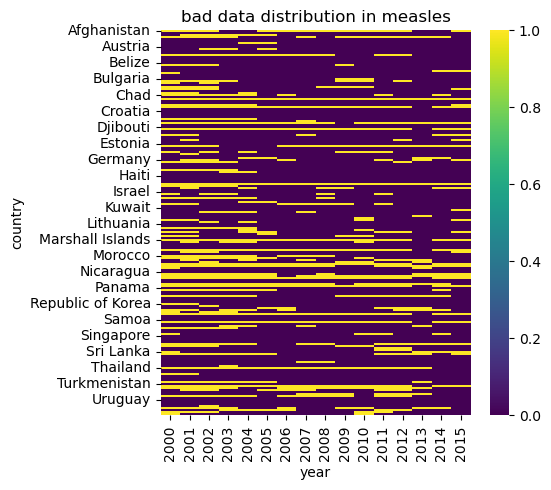

In [24]:
# check distribution of bad data in measles
df_meas = df.loc[:, ["country", "year", "measles"]]
df_meas["meas_nan"] = df["measles"].apply(lambda x: np.nan if (x > 1000) else x)

meas_pivot = pd.pivot_table(df_meas, values="meas_nan", columns=["year"], index=["country"], dropna=False)

plt.figure(figsize=(5,5))
plt.title("bad data distribution in measles")
sns.heatmap(meas_pivot.isnull(), cmap="viridis")
plt.show()

In [25]:
meas_median = np.median(df["measles"])
df["measles"] = df["measles"].apply(lambda x: meas_median if x > limit_dict["measles"][1] else x)

print(len(df[df["measles"] > limit_dict["measles"][1]]))

0


## 6. Categorical variables

In [26]:
# investigate cardinality of categorical variables
df_cat = df.select_dtypes(include="object")

for column in df_cat.columns:
    print(f"column: {column}, # of unique values: {len(df[column].unique())}")

column: country, # of unique values: 192
column: status, # of unique values: 2


In [27]:
# encode status variable using label encoding
df["status"] = df["status"].apply(lambda x: 1 if x == "Developed" else 0)

print(df["status"].unique())

[0 1]


In [28]:
# remove country variable from dataset
df.drop(columns=["country"], inplace=True)

## 7. Imputation of missing values

In [29]:
# use multiple imputation
mice_imp = IterativeImputer(max_iter=10, random_state=0)
df_imp = pd.DataFrame(mice_imp.fit_transform(df), columns=df.columns)

print(df_imp.isnull().any())

year                               False
status                             False
life_expectancy                    False
adult_mortality                    False
infant_deaths                      False
alcohol                            False
percentage_expenditure             False
hepatitis_b                        False
measles                            False
under_five_deaths                  False
polio                              False
total_expenditure                  False
diphtheria                         False
hiv/aids                           False
gdp                                False
population                         False
thinness_1_19_years                False
thinness_5_9_years                 False
income_composition_of_resources    False
schooling                          False
dtype: bool


## 8. Data normalization

In [30]:
# normalize data using min max scaler
mm_scaler = MinMaxScaler()
df_norm = pd.DataFrame(mm_scaler.fit_transform(df_imp), columns=df_imp.columns)

df_norm.describe()

,year,status,life_expectancy,adult_mortality,infant_deaths,alcohol,percentage_expenditure,hepatitis_b,measles,under_five_deaths,polio,total_expenditure,diphtheria,hiv/aids,gdp,population,thinness_1_19_years,thinness_5_9_years,income_composition_of_resources,schooling
count,2922.000000,2922.000000,2922.000000,2922.000000,2922.000000,2922.000000,2922.000000,2922.000000,2922.000000,2922.000000,2922.000000,2922.000000,2922.000000,2922.000000,2922.000000,2922.000000,2922.000000,2922.000000,2922.000000,2922.000000
mean,0.501255,0.175222,0.625154,0.226973,0.039907,0.357563,0.038096,0.782413,0.076341,0.034296,0.828984,0.322956,0.828294,0.032678,0.087132,0.038242,0.209140,0.206661,0.661062,0.579335
std,0.307591,0.380222,0.180885,0.172110,0.105243,0.192432,0.102293,0.250770,0.172284,0.092743,0.243667,0.140369,0.243896,0.100802,0.108213,0.089411,0.184863,0.184734,0.221265,0.160676
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.266667,0.000000,0.508539,0.101108,0.000000,0.184934,0.000238,0.716023,0.000000,0.000000,0.781250,0.230557,0.783505,0.000000,0.036678,0.001598,0.067873,0.066667,0.517837,0.484695
50%,0.533333,0.000000,0.679317,0.198061,0.005208,0.314009,0.003399,0.885866,0.016016,0.004242,0.937500,0.315148,0.938144,0.000000,0.048526,0.013931,0.149321,0.146667,0.714135,0.595107
75%,0.800000,0.000000,0.747628,0.314404,0.036458,0.503946,0.022842,0.958058,0.040040,0.027572,0.979167,0.407429,0.979381,0.013861,0.074434,0.038242,0.316742,0.311111,0.821730,0.690821
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
